In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
k_max = 10000
t = np.linspace(0, k_max, k_max)  # Time variable

# Generate random inputs
u = 2 * np.random.uniform(-5, 5, k_max)

# Initialize y(k) array
y = np.zeros(k_max)

# Define y(k) calculations
for k in range(1, k_max):
    y[k] = 1 / (1 + (y[k-1])**2) + 0.25 * u[k] - 0.3 * u[k-1]

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
y_k_1 = np.zeros(k_max)
y_k_2 = np.zeros(k_max)
u_k_1 = np.zeros(k_max)
u_k_2 = np.zeros(k_max)

y_k_1[1:] = y[:-1]
y_k_2[2:] = y[:-2]
u_k_1[1:] = u[:-1]
u_k_2[2:] = u[:-2]

In [3]:
t.shape, u.shape, y.shape, y_k_1.shape, y_k_2.shape, u_k_1.shape, u_k_2.shape

((10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,))

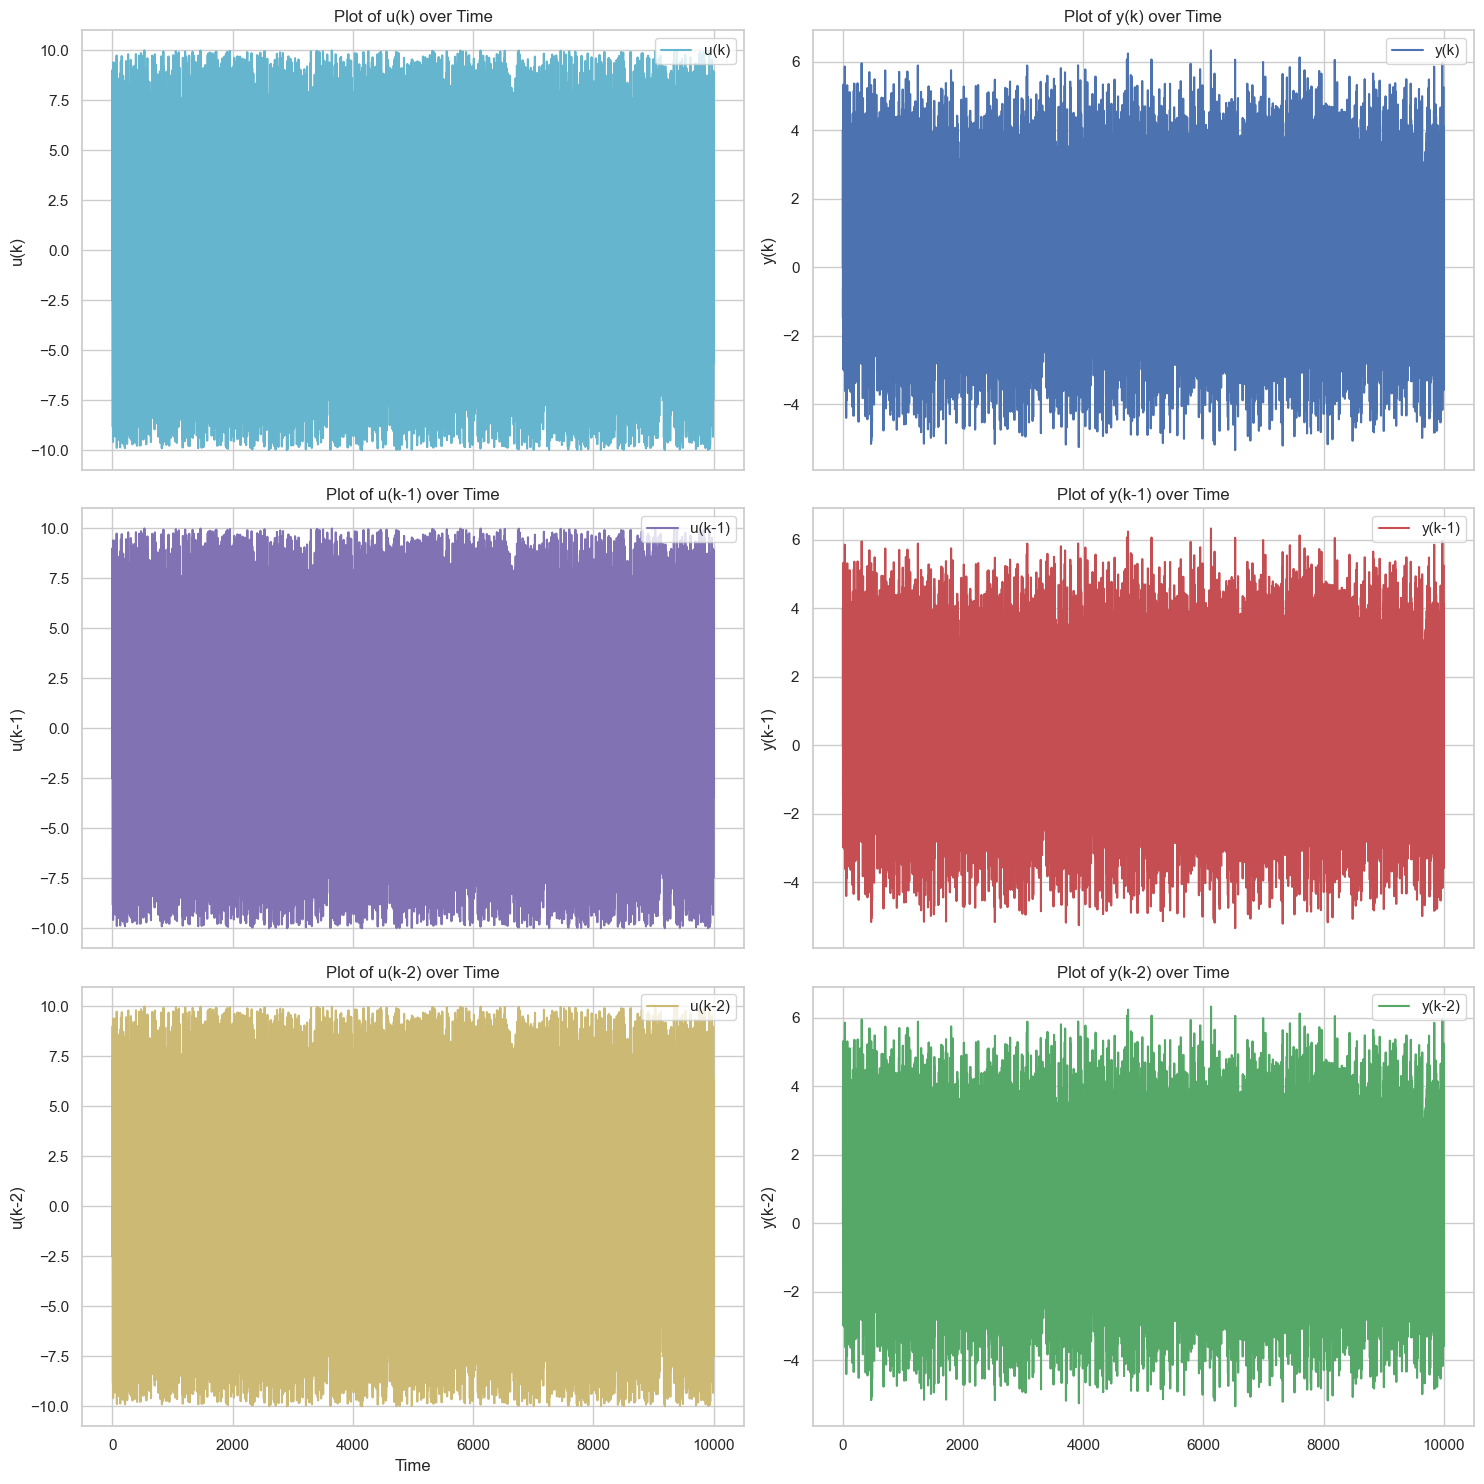

In [4]:
# Set up Seaborn style
sns.set_theme(style="whitegrid")

# Create a single figure with a 3x2 grid of subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

# Plot u(k) over time
ax[0, 0].plot(t, u, label='u(k)', color='c')
ax[0, 0].set_ylabel('u(k)')
ax[0, 0].set_title('Plot of u(k) over Time')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Plot y(k) over time
ax[0, 1].plot(t, y, label='y(k)', color='b')
ax[0, 1].set_ylabel('y(k)')
ax[0, 1].set_title('Plot of y(k) over Time')
ax[0, 1].legend()
ax[0, 1].grid(True)

# Plot u(k-1) over time
ax[1, 0].plot(t, u_k_1, label='u(k-1)', color='m')
ax[1, 0].set_ylabel('u(k-1)')
ax[1, 0].set_title('Plot of u(k-1) over Time')
ax[1, 0].legend()
ax[1, 0].grid(True)

# Plot y(k-1) over time
ax[1, 1].plot(t, y_k_1, label='y(k-1)', color='r')
ax[1, 1].set_ylabel('y(k-1)')
ax[1, 1].set_title('Plot of y(k-1) over Time')
ax[1, 1].legend()
ax[1, 1].grid(True)

# Plot u(k-2) over time
ax[2, 0].plot(t, u_k_2, label='u(k-2)', color='y')
ax[2, 0].set_xlabel('Time')
ax[2, 0].set_ylabel('u(k-2)')
ax[2, 0].set_title('Plot of u(k-2) over Time')
ax[2, 0].legend()
ax[2, 0].grid(True)

# Plot y(k-2) over time
ax[2, 1].plot(t, y_k_2, label='y(k-2)', color='g')
ax[2, 1].set_ylabel('y(k-2)')
ax[2, 1].set_title('Plot of y(k-2) over Time')
ax[2, 1].legend()
ax[2, 1].grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()

In [5]:
X = np.column_stack((u, u_k_1, u_k_2, y_k_1, y_k_2))
y = y.reshape(-1, 1)
u = u.reshape(-1, 1)
u_k_1 = u_k_1.reshape(-1, 1)
u_k_2 = u_k_2.reshape(-1, 1)
y_k_1 = y_k_1.reshape(-1, 1)
y_k_2 = y_k_2.reshape(-1, 1)

In [6]:
input_scaler = MinMaxScaler(feature_range=(-1, 1))
input_scaler.fit(u.reshape(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler.fit(y.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [7]:
u_norm = input_scaler.transform(u.reshape(-1, 1)).flatten()
y_norm = output_scaler.transform(y.reshape(-1, 1)).flatten()
u_k_1_norm = input_scaler.transform(u_k_1.reshape(-1, 1)).flatten()
u_k_2_norm = input_scaler.transform(u_k_2.reshape(-1, 1)).flatten()
y_k_1_norm = output_scaler.transform(y_k_1.reshape(-1, 1)).flatten()
y_k_2_norm = output_scaler.transform(y_k_2.reshape(-1, 1)).flatten()

In [8]:
# Define the arrays for each variable
X_norm = np.column_stack((u_norm, u_k_1_norm, u_k_2_norm, y_k_1_norm, y_k_2_norm))
y_norm = y_norm.reshape(-1, 1)
u_norm = u_norm.reshape(-1, 1)
u_k_1_norm = u_k_1_norm.reshape(-1, 1)
u_k_2_norm = u_k_2_norm.reshape(-1, 1)
y_k_1_norm = y_k_1_norm.reshape(-1, 1)
y_k_2_norm = y_k_2_norm.reshape(-1, 1)

In [9]:
X.shape, y.shape, u.shape, u_k_1.shape, u_k_2.shape, y_k_1.shape, y_k_2.shape

((10000, 5),
 (10000, 1),
 (10000, 1),
 (10000, 1),
 (10000, 1),
 (10000, 1),
 (10000, 1))

In [10]:
X_df = pd.DataFrame(X, columns=['u', 'u(k-1)', 'u(k-2)', 'y(k-1)', 'y(k-2)'])
y_df = pd.DataFrame(y, columns=['y'])
X_norm_df = pd.DataFrame(X_norm, columns=['u', 'u(k-1)', 'u(k-2)', 'y(k-1)', 'y(k-2)'])
y_norm_df = pd.DataFrame(y_norm, columns=['y'])
df = pd.concat([X_df, y_df], axis=1)
norm_df = pd.concat([X_norm_df, y_norm_df], axis=1)

In [11]:
df.describe()

u        u(k-1)        u(k-2)        y(k-1)        y(k-2)  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.116809     -0.116243     -0.116038      0.383105      0.383365   
std        5.752603      5.752336      5.752303      2.299250      2.299059   
min       -9.999767     -9.999767     -9.999767     -5.340716     -5.340716   
25%       -5.073423     -5.072228     -5.072228     -1.265325     -1.264097   
50%       -0.149428     -0.148955     -0.148128      0.392119      0.392119   
75%        4.800127      4.800127      4.800127      2.051329      2.051329   
max        9.994353      9.994353      9.994353      6.324696      6.324696   

                  y  
count  10000.000000  
mean       0.383038  
std        2.299271  
min       -5.340716  
25%       -1.265325  
50%        0.392119  
75%        2.051329  
max        6.324696

In [12]:
norm_df.describe()

u        u(k-1)        u(k-2)        y(k-1)        y(k-2)  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.011414     -0.011357     -0.011336     -0.018668     -0.018623   
std        0.575429      0.575403      0.575399      0.394200      0.394167   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.507221     -0.507101     -0.507101     -0.301286     -0.301076   
50%       -0.014676     -0.014629     -0.014546     -0.017123     -0.017123   
75%        0.480425      0.480425      0.480425      0.267344      0.267344   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  y  
count  10000.000000  
mean      -0.018680  
std        0.394203  
min       -1.000000  
25%       -0.301286  
50%       -0.017123  
75%        0.267344  
max        1.000000

In [13]:
# Calculate the split index
split_index = int(0.8 * len(X_norm))

# Split the data
X_norm_train = X_norm[:split_index]
X_norm_val = X_norm[split_index:]
y_norm_train = y_norm[:split_index]
y_norm_val = y_norm[split_index:]

In [14]:
X_norm_train.shape, X_norm_val.shape, y_norm_train.shape, y_norm_val.shape

((8000, 5), (2000, 5), (8000, 1), (2000, 1))

In [15]:
# Define the model architecture
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_norm_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Define the path and filename for the best model
checkpoint_filepath = 'plant_tahap1.h5'  # You can choose a different path or filename

# Initialize the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',             # Metric to monitor
    verbose=1,                      # Verbosity mode
    save_best_only=True,            # Save only the best model
    save_weights_only=False,        # Set to True to save only weights
    mode='min',                     # 'min' because we want to minimize loss
    save_freq='epoch'               # Save at the end of each epoch
)

# (Optional) Initialize EarlyStopping callback
# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=50,                    # Number of epochs with no improvement after which training will be stopped
#     verbose=1,
#     restore_best_weights=True       # Restore model weights from the epoch with the best value of the monitored quantity
# )

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Calculate the full batch size
full_batch_size = X_norm_train.shape[0]

# Train the model
history = model.fit(
    X_norm_train,
    y_norm_train,
    epochs=10000,                         # You can adjust the number of epochs
    batch_size=full_batch_size,           # Typically, you might use smaller batch sizes
    validation_data=(X_norm_val, y_norm_val),
    verbose=1,
    callbacks=[checkpoint_callback]  # Add callbacks here
)

Epoch 1/10000
1/1 [==============================] - ETA: 0s - loss: 0.2288 - mean_absolute_error: 0.4004
Epoch 1: val_loss improved from inf to 0.18037, saving model to plant_tahap1.h5
1/1 [==============================] - 2s 2s/step - loss: 0.2288 - mean_absolute_error: 0.4004 - val_loss: 0.1804 - val_mean_absolute_error: 0.3547
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: 0.1885 - mean_absolute_error: 0.3630
Epoch 2: val_loss improved from 0.18037 to 0.14669, saving model to plant_tahap1.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.1885 - mean_absolute_error: 0.3630 - val_loss: 0.1467 - val_mean_absolute_error: 0.3198
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: 0.1529 - mean_absolute_error: 0.3263
Epoch 3: val_loss improved from 0.14669 to 0.11707, saving model to plant_tahap1.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.1529 - mean_absolute_error: 0.3263 - val_loss: 0.1171 - val_mean_absolute_

In [17]:
model.save('plant_tahap1.h5')

In [18]:
model = load_model('plant_tahap1.h5')

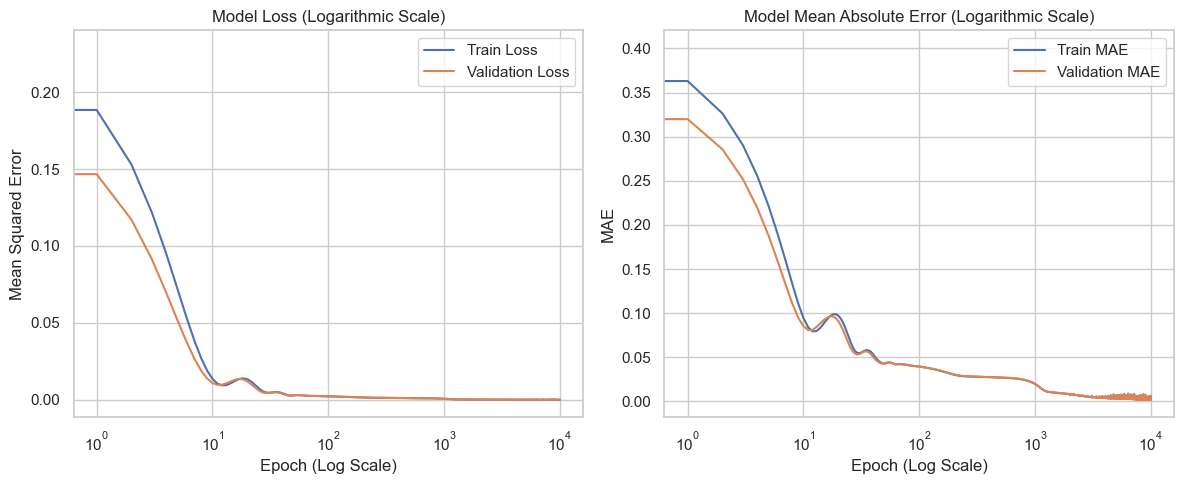

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Model Loss (Logarithmic Scale)')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch (Log Scale)')
plt.legend()
plt.grid(True)

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Model Mean Absolute Error (Logarithmic Scale)')
plt.ylabel('MAE')
plt.xlabel('Epoch (Log Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
y_norm_pred = model.predict(X_norm)
y_pred = output_scaler.inverse_transform(y_norm_pred)

313/313 [==============================] - 1s 2ms/step


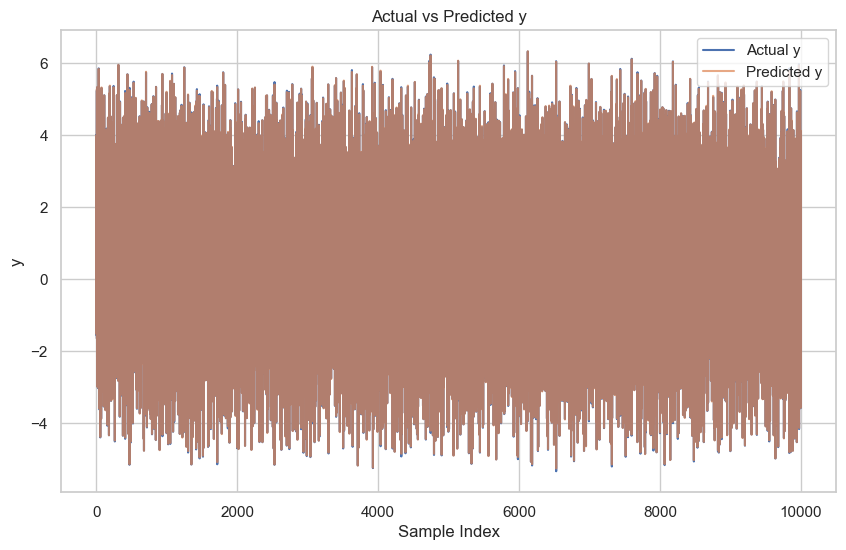

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual y')
plt.plot(y_pred, label='Predicted y', alpha=0.7)
plt.title('Actual vs Predicted y')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Generate a sine wave input
sine_wave_length = 10000
sine_wave_t = np.linspace(0, 2 * np.pi, sine_wave_length)
sine_wave_u = 10 * np.sin(10 * sine_wave_t)

# Initialize y(k) array for sine wave
sine_wave_y = np.zeros(sine_wave_length)

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
sine_wave_y_k_1 = np.zeros(sine_wave_length)
sine_wave_y_k_2 = np.zeros(sine_wave_length)
sine_wave_u_k_1 = np.zeros(sine_wave_length)
sine_wave_u_k_2 = np.zeros(sine_wave_length)

for k in range(1, k_max):
    sine_wave_y[k] = 1 / (1 + (sine_wave_y[k-1])**2) + 0.25 * sine_wave_u[k] - 0.3 * sine_wave_u[k-1]

sine_wave_y_k_1[1:] = sine_wave_y[:-1]
sine_wave_y_k_2[2:] = sine_wave_y[:-2]
sine_wave_u_k_1[1:] = sine_wave_u[:-1]
sine_wave_u_k_2[2:] = sine_wave_u[:-2]

# Normalize the sine wave input
sine_wave_u_norm = input_scaler.transform(sine_wave_u.reshape(-1, 1)).flatten()
sine_wave_u_k_1_norm = input_scaler.transform(sine_wave_u_k_1.reshape(-1, 1)).flatten()
sine_wave_u_k_2_norm = input_scaler.transform(sine_wave_u_k_2.reshape(-1, 1)).flatten()
sine_wave_y_k_1_norm = output_scaler.transform(sine_wave_y_k_1.reshape(-1, 1)).flatten()
sine_wave_y_k_2_norm = output_scaler.transform(sine_wave_y_k_2.reshape(-1, 1)).flatten()

# Define the arrays for each variable
sine_wave_X_norm = np.column_stack((sine_wave_u_norm, sine_wave_u_k_1_norm, sine_wave_u_k_2_norm, sine_wave_y_k_1_norm, sine_wave_y_k_2_norm))

In [26]:
# Predict the output using the trained model
sine_wave_y_norm_pred = model.predict(sine_wave_X_norm)
sine_wave_y_pred = output_scaler.inverse_transform(sine_wave_y_norm_pred)

313/313 [==============================] - 1s 2ms/step


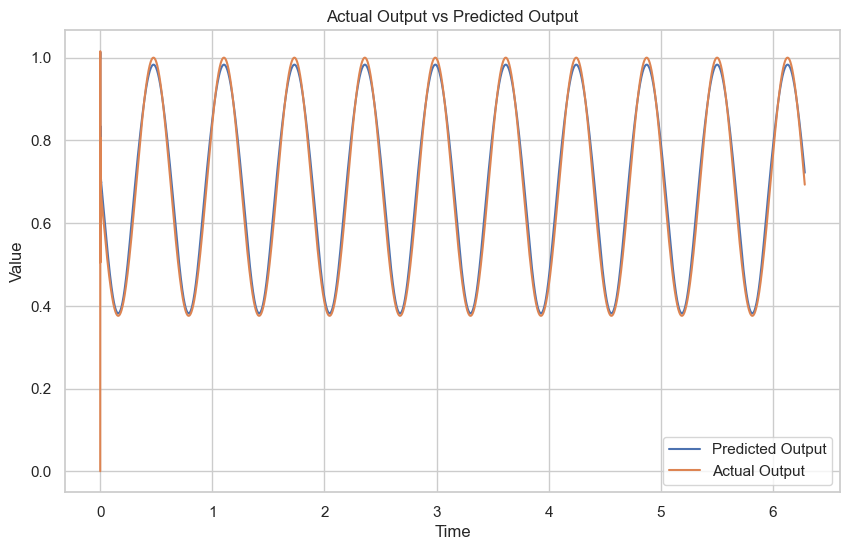

In [27]:
# Plot the actual sine wave input and the predicted output
plt.figure(figsize=(10, 6))
# plt.plot(sine_wave_t, sine_wave_u, label='Sine Wave Input')
plt.plot(sine_wave_t, sine_wave_y_pred, label='Predicted Output')
plt.plot(sine_wave_t, sine_wave_y, label='Actual Output')
plt.title('Actual Output vs Predicted Output')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model = load_model('plant_tahap1.h5')

In [29]:
import copy

# Number of training samples
num_train = X_norm_train.shape[0]
num_val = X_norm_val.shape[0]

# Initialize previous predictions (in normalized scale)
y_pred_prev1 = 0.0  # y_pred(k-1)
y_pred_prev2 = 0.0  # y_pred(k-2)

# Prepare a copy of training data to manipulate
X_train_feedback = X_norm_train.copy()
y_train_feedback = y_norm_train.copy()

# Replace the y(k-1) and y(k-2) in training data with initial zeros
X_train_feedback[:, 3] = 0.0  # y(k-1)
X_train_feedback[:, 4] = 0.0  # y(k-2)

# Initialize lists to store training metrics
train_loss_list = []
train_mae_list = []

# Initialize lists to store validation metrics
val_loss_list = []
val_mae_list = []

# Initialize variables to track the best model
best_loss = np.inf
best_weights = None  # To store the best weights

In [30]:
from tqdm import tqdm  # For a progress bar

# Initialize training and validation metrics for all epochs
train_loss_epochs = []
train_mae_epochs = []
val_loss_epochs = []
val_mae_epochs = []

# Number of epochs
num_epochs = 100

# Training with feedback for multiple epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Reset previous predictions
    y_pred_prev1 = np.zeros((num_train,))  # y(k-1) for all samples
    y_pred_prev2 = np.zeros((num_train,))  # y(k-2) for all samples
    
    # Process training samples in batches
    train_loss_epoch = 0.0
    train_mae_epoch = 0.0
    for k in tqdm(range(num_train), desc="Training Progress"):
        # Prepare input vector with updated feedback
        X_train_feedback[k, 3] = y_pred_prev1[k]  # y(k-1)
        X_train_feedback[k, 4] = y_pred_prev2[k]  # y(k-2)
        
        # Perform a single gradient update
        loss, mae = model.train_on_batch(X_train_feedback[k:k+1], y_train_feedback[k:k+1])
        train_loss_epoch += loss
        train_mae_epoch += mae

        # Predict current sample
        y_pred = model.predict(X_train_feedback[k:k+1], verbose=0)
        
        # Update feedback predictions
        y_pred_prev2[k] = y_pred_prev1[k]
        y_pred_prev1[k] = y_pred.flatten()[0]
    
    # Store epoch metrics for training
    train_loss_epochs.append(train_loss_epoch / num_train)
    train_mae_epochs.append(train_mae_epoch / num_train)

    # Validation phase
    y_val_prev1 = 0.0
    y_val_prev2 = 0.0
    y_val_true_list = []
    y_val_pred_list = []

    val_loss_epoch = 0.0
    val_mae_epoch = 0.0

    for k in tqdm(range(num_val), desc="Validation Progress"):
        # Prepare input vector for validation
        X_val_feedback = X_norm_val[k:k+1]
        X_val_feedback[:, 3] = y_val_prev1
        X_val_feedback[:, 4] = y_val_prev2

        # Predict validation sample
        y_pred = model.predict(X_val_feedback, verbose=0)
        y_val_pred_list.append(y_pred.flatten()[0])
        y_val_true_list.append(y_norm_val[k].flatten()[0])

        # Calculate loss and MAE
        loss = np.mean((y_norm_val[k] - y_pred) ** 2)
        mae = np.mean(np.abs(y_norm_val[k] - y_pred))
        val_loss_epoch += loss
        val_mae_epoch += mae

        # Update feedback
        y_val_prev2 = y_val_prev1
        y_val_prev1 = y_pred.flatten()[0]
    
    # Store epoch metrics for validation
    val_loss_epochs.append(val_loss_epoch / num_val)
    val_mae_epochs.append(val_mae_epoch / num_val)

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss_epochs[-1]:.6f}, Train MAE: {train_mae_epochs[-1]:.6f}")
    print(f"              - Val Loss: {val_loss_epochs[-1]:.6f}, Val MAE: {val_mae_epochs[-1]:.6f}")

Epoch 1/100


Training Progress:   9%|▉         | 759/8000 [00:44<07:01, 17.20it/s]


KeyboardInterrupt: 

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_epochs, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_epochs, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_mae_epochs, label='Train MAE')
plt.plot(range(1, num_epochs + 1), val_mae_epochs, label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
model.save('plant_tahap2.h5')

In [36]:
model = load_model('plant_tahap2.h5')

In [37]:
y_norm_pred_feedback = model.predict(X_norm)
y_pred_feedback = output_scaler.inverse_transform(y_norm_pred_feedback)

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual y')
plt.plot(y_pred_feedback, label='Predicted y (Feedback)')
plt.title('Actual vs Predicted y (Feedback)')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Predict the output using the trained model
sine_wave_y_norm_pred_feedback = model.predict(sine_wave_X_norm)
sine_wave_y_pred_feedback = output_scaler.inverse_transform(sine_wave_y_norm_pred_feedback)

In [40]:
# Plot the actual sine wave input and the predicted output
plt.figure(figsize=(10, 6))
# plt.plot(sine_wave_t, sine_wave_u, label='Sine Wave Input')
plt.plot(sine_wave_t, sine_wave_y_pred_feedback, label='Predicted Output')
plt.plot(sine_wave_t, sine_wave_y, label='Actual Output')
plt.title('Actual Output vs Predicted Output')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
mse_random = np.mean((y - y_pred) ** 2)
mse_feedback_random = np.mean((y - y_pred_feedback) ** 2)
print(f"MSE without Feedback (Random Input): {mse_random:.6f}")
print(f"MSE with Feedback (Random Input): {mse_feedback_random:.6f}")

In [42]:
mse = np.mean((sine_wave_y - sine_wave_y_pred) ** 2)
mse_feedback = np.mean((sine_wave_y - sine_wave_y_pred_feedback) ** 2)
print(f"MSE without Feedback: {mse:.6f}")
print(f"MSE with Feedback: {mse_feedback:.6f}")

In [43]:
np.save('y_pred_feedback.npy', y_pred_feedback)